In [1]:
import pandas as pd
import numpy as np
try:
    import SimpleITK as sitk
except:
    ! pip install SimpleITK
    import SimpleITK as sitk
    
import matplotlib.pyplot as plt
import os
import glob

In [14]:
filename = '/mnt/MI_LUNG/vinbigdata/train/ae5cec1517ab3e82c5374e4c6219a17d.dicom'

('0010|0040',
 '0010|1010',
 '0028|0002',
 '0028|0004',
 '0028|0010',
 '0028|0011',
 '0028|0030',
 '0028|0100',
 '0028|0101',
 '0028|0102',
 '0028|0103',
 '0028|1050',
 '0028|1051',
 '0028|2110',
 '0028|2112',
 'ITK_original_direction',
 'ITK_original_spacing')

In [30]:
dcm = sitk.ReadImage(filename)
metadata_keys = dcm.GetMetaDataKeys()
metadata_keys = [k for k in metadata_keys if '|' in k]

for k in metadata_keys:
    print(f'{k}: {dcm.GetMetaData(k)}')
    
im = sitk.GetArrayFromImage(dcm) # Numpy array
im = np.squeeze(im)

0010|0040: M 
0010|1010: 000D
0028|0002: 1
0028|0004: MONOCHROME1 
0028|0010: 2688
0028|0011: 2208
0028|0030: 1\1 
0028|0100: 16
0028|0101: 16
0028|0102: 15
0028|0103: 0
0028|1050: 35101 
0028|1051: 31304 
0028|2110: 00
0028|2112: 2 


GDCMImageIO (0x7f559801a0f0): Converting from MONOCHROME1 to MONOCHROME2 may impact the meaning of DICOM attributes related to pixel values.



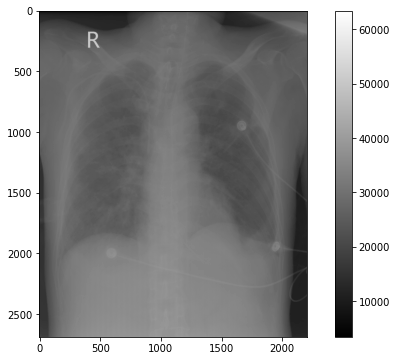

In [31]:
plt.figure(figsize=(10,6))
plt.imshow(im, cmap='gray')
plt.colorbar()
plt.show()

In [8]:
df = pd.read_csv('/mnt/MI_LUNG/vinbigdata/train.csv')
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [9]:
df[df['image_id'] == os.path.splitext(os.path.basename(filename))[0]]

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
6764,ae5cec1517ab3e82c5374e4c6219a17d,Infiltration,6,R9,133.0,726.0,832.0,1931.0
20903,ae5cec1517ab3e82c5374e4c6219a17d,ILD,5,R10,208.0,737.0,729.0,1932.0
23700,ae5cec1517ab3e82c5374e4c6219a17d,Lung Opacity,7,R9,133.0,726.0,832.0,1931.0
28726,ae5cec1517ab3e82c5374e4c6219a17d,Aortic enlargement,0,R9,1041.0,782.0,1327.0,1180.0
35049,ae5cec1517ab3e82c5374e4c6219a17d,Pleural thickening,11,R8,1738.0,727.0,1855.0,970.0


## Pytorch

In [94]:
import torch
from torch import nn
from torchvision import models, transforms

from skimage.transform import resize

In [95]:
# With this will be able to use a pretrained neural network as feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self, model_name: str, pretrained: bool = True) -> None:
        super().__init__()
        self.model_name = model_name
        self.pretrained = pretrained
        self.model = self._get_model()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.model(x)
        features = features.view(features.size(0), -1)
        return features

    def _get_model(self) -> nn.Module:
        if self.model_name == 'resnet18':
            model = models.resnet18(pretrained=self.pretrained)
            modules = list(model.children())[:-1]
            model = torch.nn.Sequential(*modules)
        elif self.model_name == 'resnet34':
            model = models.resnet34(pretrained=self.pretrained)
            modules = list(model.children())[:-1]
            model = torch.nn.Sequential(*modules)
        elif self.model_name == 'resnet50':
            model = models.resnet50(pretrained=self.pretrained)
            modules = list(model.children())[:-1]
            model = torch.nn.Sequential(*modules)
        else:
            raise ValueError(f'Invalid model name: {self.model_name}')
        return model

Number of features: 2048


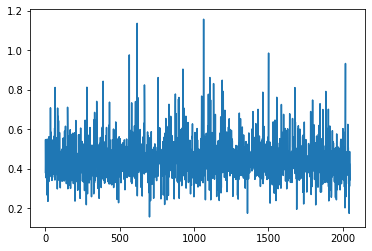

In [96]:
# Example of extracting features from an image 

model = FeatureExtractor('resnet50')
x = torch.rand(1, 3, 256, 256) # This will be the image

feats = model(x)
feats = feats.detach().cpu().numpy()[0]

print(f'Number of features: {feats.shape[0]}')

plt.plot(range(feats.shape[0]), feats)
plt.show()

In [123]:
model = FeatureExtractor('resnet50')

# Extracting feature from xray
for f in [filename]: 
    dcm = sitk.ReadImage(f)
    im = sitk.GetArrayFromImage(dcm) # Numpy array
    im = np.squeeze(im)
    
    # rescale to [0,1]
    im = im / (2**16) # TODO: Check maximum to rescale
    
    # resize according to the size of the disease
    im = resize(im, (256, 256)) # TODO: Check minimum size
    
    im = np.expand_dims(im, axis=0)
    im = np.repeat(im, 3, axis=0)
    im = np.expand_dims(im, axis=0)
    
    # extract features
    feats = model(torch.from_numpy(im).float())
    feats = feats.detach().cpu().numpy()[0]

    
# TODO: Create a dataset with the new features linking the name of the file and the label (class)
# TODO: Check scikit-learn to train a SVM model for classification

GDCMImageIO (0x5637b350ec40): Converting from MONOCHROME1 to MONOCHROME2 may impact the meaning of DICOM attributes related to pixel values.



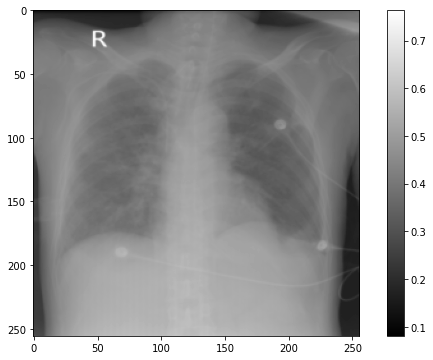

In [126]:
plt.figure(figsize=(10,6))
plt.imshow(im[0,0,...], cmap='gray')
plt.colorbar()
plt.show()